Saving artefacts to: /home/roberh18/IKT452/Project/outputs/20250421_005458
>>>   Model: efficientnet, Dataset: FER2013   <<<
Calculating mean and std …
Dataset mean:  [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:   [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]

Begin training …
Epoch   1/60 | Train L: 1.4464 A: 0.4973 | Val L: 1.1930 A: 0.6323 | F1: 0.6190 | 84.8s
Epoch   2/60 | Train L: 1.2715 A: 0.5942 | Val L: 1.1521 A: 0.6541 | F1: 0.6447 | 83.3s
Epoch   3/60 | Train L: 1.2107 A: 0.6283 | Val L: 1.1677 A: 0.6584 | F1: 0.6415 | 83.2s
Epoch   4/60 | Train L: 1.1633 A: 0.6498 | Val L: 1.1069 A: 0.6828 | F1: 0.6767 | 83.5s
Epoch   5/60 | Train L: 1.1231 A: 0.6720 | Val L: 1.1224 A: 0.6828 | F1: 0.6763 | 82.6s
Epoch   6/60 | Train L: 1.0895 A: 0.6896 | Val L: 1.0997 A: 0.7009 | F1: 0.6979 | 82.1s
Epoch   7/60 | Train L: 1.0562 A: 0.7085 | Val L: 1.1099 A: 0.6969 | F1: 0.6930 | 82.9s
Epoch   8/60 | Train L: 1.0173 A: 0.7306 | Val L: 1.1229 A: 0.

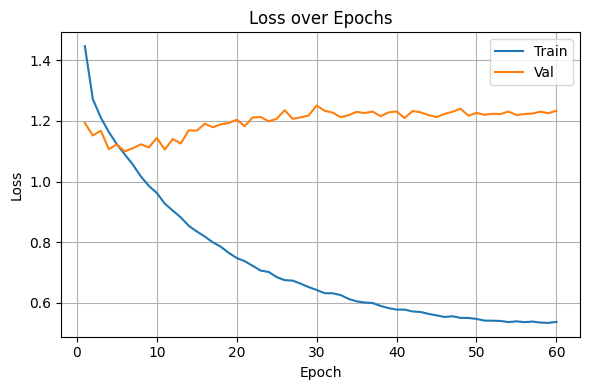

Saved loss plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_005458/loss_epochs.png


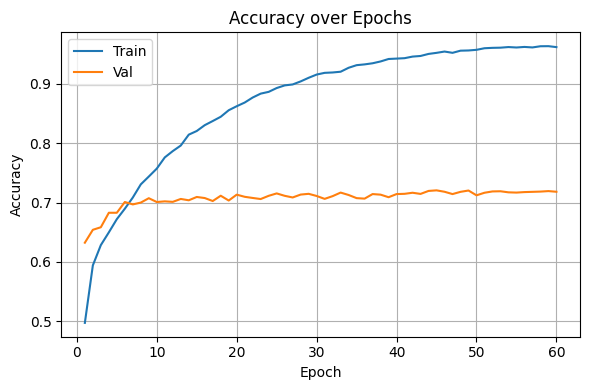

Saved accuracy plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_005458/accuracy_epochs.png

Final evaluation:
Precision: 0.7213, Recall: 0.7205, F1: 0.7196


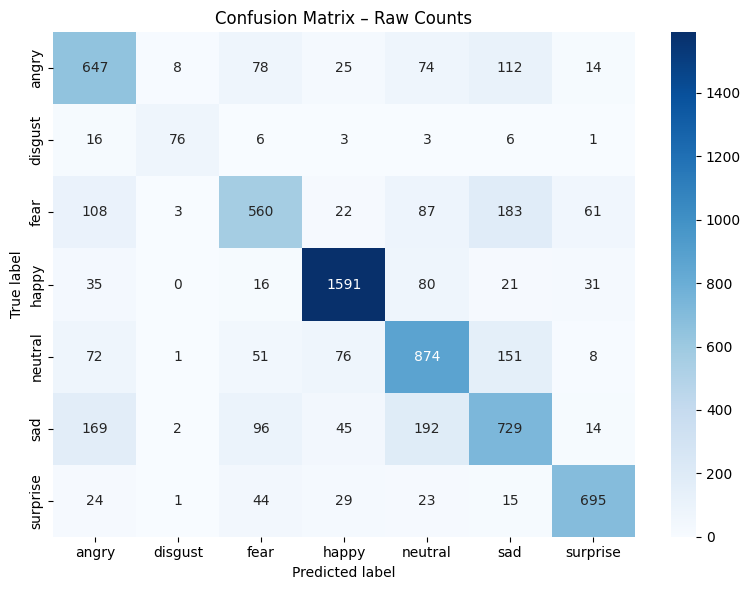

Saved confusion matrix ➜ /home/roberh18/IKT452/Project/outputs/20250421_005458/confusion_matrix.png


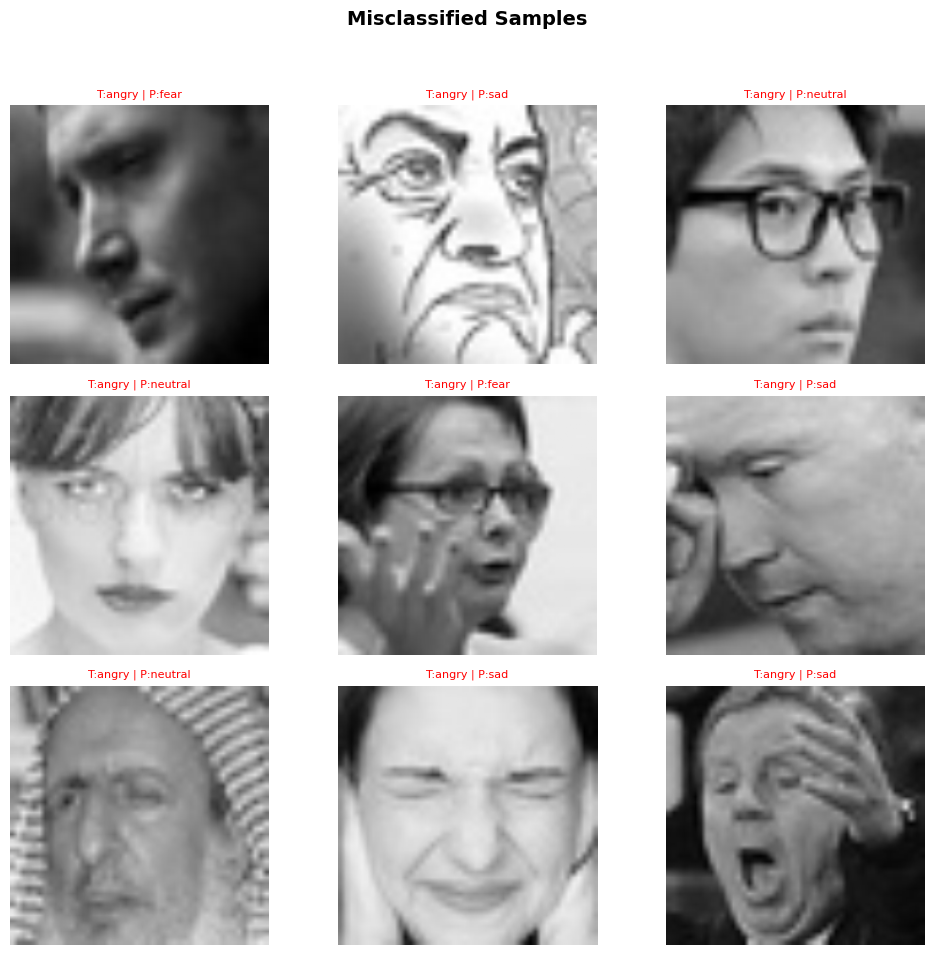

Saved mis‑classified sample grid ➜ /home/roberh18/IKT452/Project/outputs/20250421_005458/misclassified_samples.png
Saved best weights ➜ /home/roberh18/IKT452/Project/outputs/20250421_005458/models/efficientnet_best.pth


In [1]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------------------------------------
# Configurations and Hyper‑parameters
# ------------------------------------------------------------
MODEL_NAME   = "efficientnet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                             # 60 to match best experiment, can be changed
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
# Output folder (works in scripts *and* notebooks)
# ------------------------------------------------------------
try:
    base_dir = Path(__file__).resolve().parent        # running as a script
except NameError:
    base_dir = Path.cwd()                             # running in a notebook

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g. 20250421_140355
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving artefacts to: {OUT_DIR}")

print(f">>>   Model: {MODEL_NAME}, Dataset: FER2013   <<<")

# ------------------------------------------------------------
# Dataset helpers
# ------------------------------------------------------------

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std (channel‑wise)."""
    print("Calculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# ------------------------------------------------------------
# Transforms & loaders (randaugment_plus default)
# ------------------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

# ------------------------------------------------------------
# Model factory
# ------------------------------------------------------------

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# ------------------------------------------------------------
# Training utilities
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# ------------------------------------------------------------
# Plots – each metric in a separate figure, saved + shown
# ------------------------------------------------------------

epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot ➜ {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot ➜ {acc_path}")

# ------------------------------------------------------------
# Final evaluation & Confusion matrix (+ plot)
# ------------------------------------------------------------

model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix ➜ {cm_path}")

# ------------------------------------------------------------
# Mis‑classified samples helper functions
# ------------------------------------------------------------

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid ➜ {fig_path}")

# ------------------------------------------------------------
# Show some misclassified examples (and save grid)
# ------------------------------------------------------------
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

# ------------------------------------------------------------
# Save model weights last (so folder contains every artefact)
# ------------------------------------------------------------
model_dir = os.path.join(OUT_DIR, "models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
torch.save(best_weights, model_path)
print(f"Saved best weights ➜ {model_path}")



Saving artefacts to: /home/roberh18/IKT452/Project/outputs/20250421_021915
>>>   Model: mobilenet, Dataset: FER2013   <<<
Calculating mean and std …
Dataset mean:  [0.507876455783844, 0.507876455783844, 0.507876455783844]
Dataset std:   [0.25019553303718567, 0.25019553303718567, 0.25019553303718567]

Begin training …
Epoch   1/60 | Train L: 1.4764 A: 0.4819 | Val L: 1.2938 A: 0.5756 | F1: 0.5578 | 32.4s
Epoch   2/60 | Train L: 1.3247 A: 0.5632 | Val L: 1.2639 A: 0.6031 | F1: 0.5857 | 32.7s
Epoch   3/60 | Train L: 1.2760 A: 0.5901 | Val L: 1.2019 A: 0.6364 | F1: 0.6292 | 32.2s
Epoch   4/60 | Train L: 1.2412 A: 0.6049 | Val L: 1.1926 A: 0.6503 | F1: 0.6487 | 32.8s
Epoch   5/60 | Train L: 1.2114 A: 0.6235 | Val L: 1.1509 A: 0.6584 | F1: 0.6512 | 32.7s
Epoch   6/60 | Train L: 1.1865 A: 0.6371 | Val L: 1.1582 A: 0.6549 | F1: 0.6486 | 33.5s
Epoch   7/60 | Train L: 1.1709 A: 0.6482 | Val L: 1.1250 A: 0.6771 | F1: 0.6724 | 34.6s
Epoch   8/60 | Train L: 1.1451 A: 0.6608 | Val L: 1.1412 A: 0.674

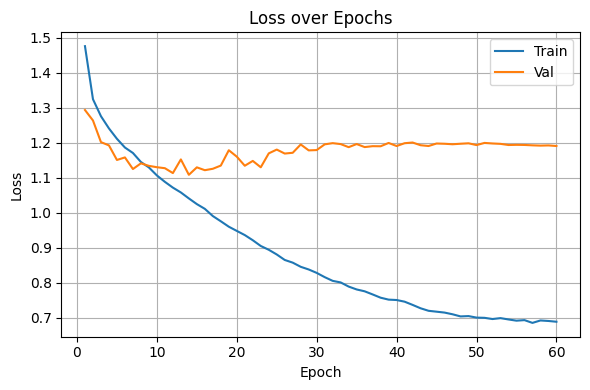

Saved loss plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_021915/loss_epochs.png


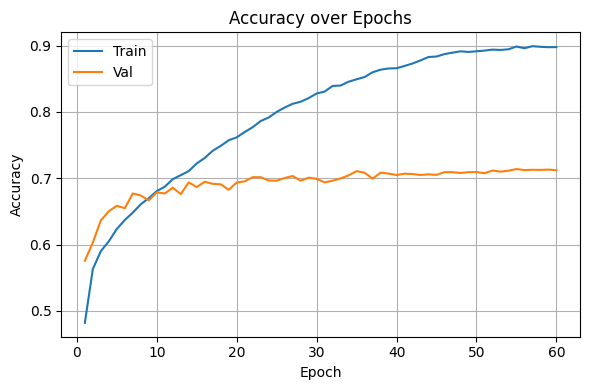

Saved accuracy plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_021915/accuracy_epochs.png

Final evaluation:
Precision: 0.7136, Recall: 0.7138, F1: 0.7134


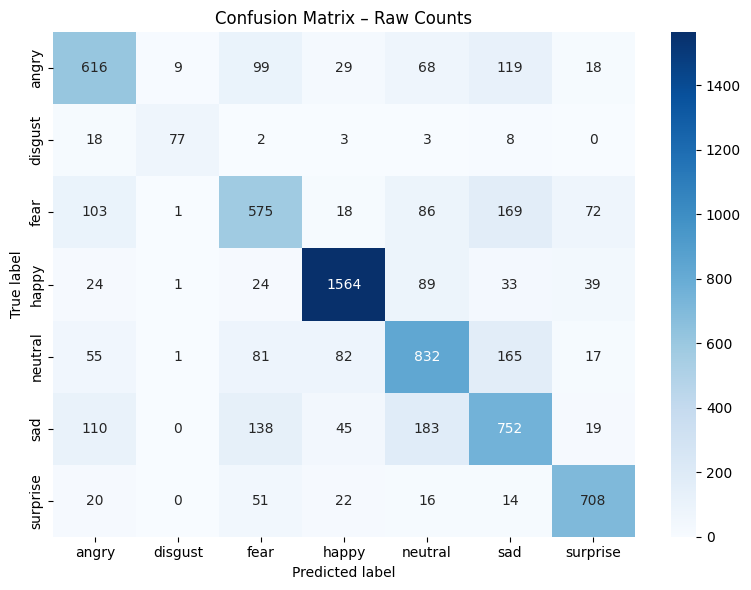

Saved confusion matrix ➜ /home/roberh18/IKT452/Project/outputs/20250421_021915/confusion_matrix.png


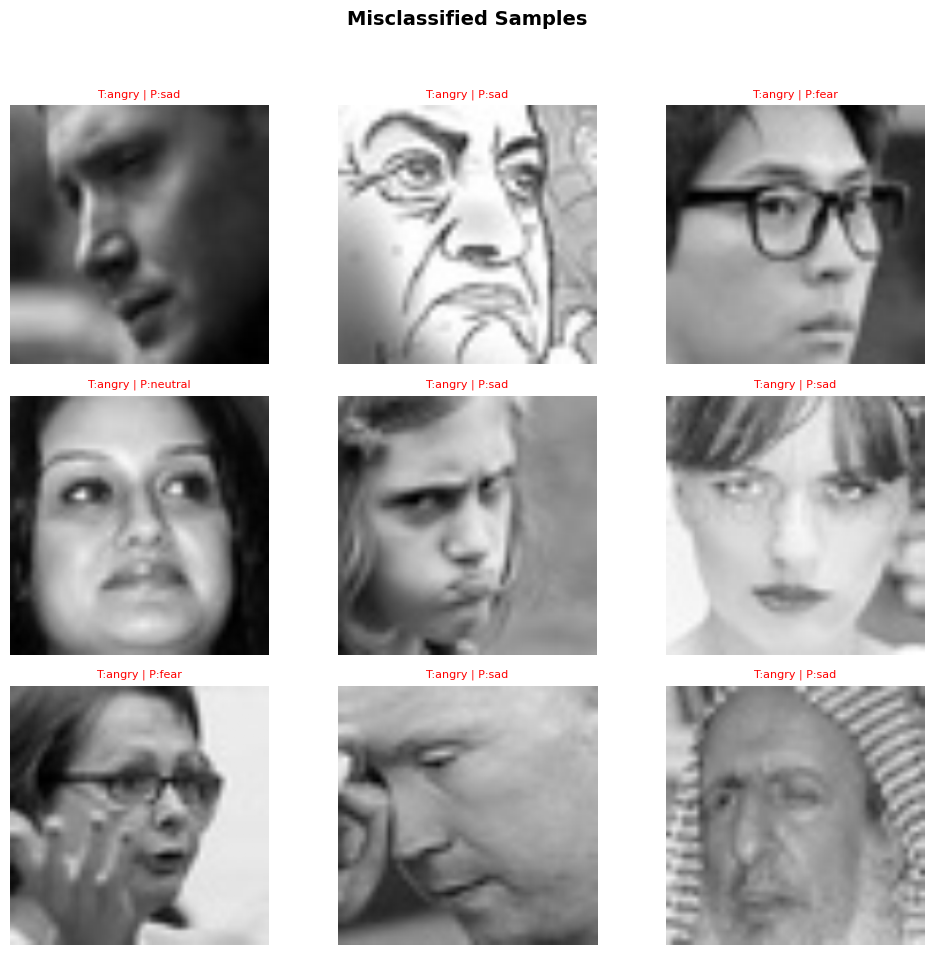

Saved mis‑classified sample grid ➜ /home/roberh18/IKT452/Project/outputs/20250421_021915/misclassified_samples.png
Saved best weights ➜ /home/roberh18/IKT452/Project/outputs/20250421_021915/models/mobilenet_best.pth


In [2]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------------------------------------
# Configurations and Hyper‑parameters
# ------------------------------------------------------------
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
#DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                             # 60 to match best experiment, can be changed
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
# Output folder (works in scripts *and* notebooks)
# ------------------------------------------------------------
try:
    base_dir = Path(__file__).resolve().parent        # running as a script
except NameError:
    base_dir = Path.cwd()                             # running in a notebook

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g. 20250421_140355
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving artefacts to: {OUT_DIR}")

print(f">>>   Model: {MODEL_NAME}, Dataset: FER2013   <<<")

# ------------------------------------------------------------
# Dataset helpers
# ------------------------------------------------------------

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std (channel‑wise)."""
    print("Calculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# ------------------------------------------------------------
# Transforms & loaders (randaugment_plus default)
# ------------------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

# ------------------------------------------------------------
# Model factory
# ------------------------------------------------------------

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# ------------------------------------------------------------
# Training utilities
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# ------------------------------------------------------------
# Plots – each metric in a separate figure, saved + shown
# ------------------------------------------------------------

epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot ➜ {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot ➜ {acc_path}")

# ------------------------------------------------------------
# Final evaluation & Confusion matrix (+ plot)
# ------------------------------------------------------------

model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix ➜ {cm_path}")

# ------------------------------------------------------------
# Mis‑classified samples helper functions
# ------------------------------------------------------------

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid ➜ {fig_path}")

# ------------------------------------------------------------
# Show some misclassified examples (and save grid)
# ------------------------------------------------------------
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

# ------------------------------------------------------------
# Save model weights last (so folder contains every artefact)
# ------------------------------------------------------------
model_dir = os.path.join(OUT_DIR, "models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
torch.save(best_weights, model_path)
print(f"Saved best weights ➜ {model_path}")


Saving artefacts to: /home/roberh18/IKT452/Project/outputs/20250421_025315
>>>   Model: efficientnet, Dataset: FERPlus   <<<
Calculating mean and std …
Dataset mean:  [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:   [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]

Begin training …
Epoch   1/60 | Train L: 1.1733 A: 0.6736 | Val L: 0.9063 A: 0.8029 | F1: 0.7877 | 99.9s
Epoch   2/60 | Train L: 0.9868 A: 0.7611 | Val L: 0.8659 A: 0.8148 | F1: 0.8078 | 99.4s
Epoch   3/60 | Train L: 0.9352 A: 0.7830 | Val L: 0.8487 A: 0.8283 | F1: 0.8190 | 94.7s
Epoch   4/60 | Train L: 0.8955 A: 0.8033 | Val L: 0.8464 A: 0.8225 | F1: 0.8206 | 97.5s
Epoch   5/60 | Train L: 0.8668 A: 0.8163 | Val L: 0.8267 A: 0.8394 | F1: 0.8323 | 95.4s
Epoch   6/60 | Train L: 0.8413 A: 0.8274 | Val L: 0.8295 A: 0.8394 | F1: 0.8361 | 100.0s
Epoch   7/60 | Train L: 0.8193 A: 0.8376 | Val L: 0.8259 A: 0.8407 | F1: 0.8364 | 100.1s
Epoch   8/60 | Train L: 0.7971 A: 0.8484 | Val L: 0.8232 A: 

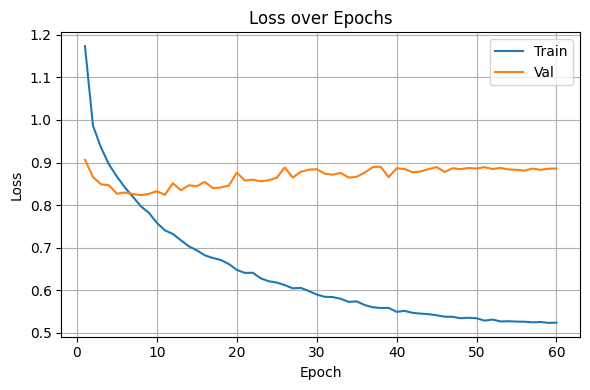

Saved loss plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_025315/loss_epochs.png


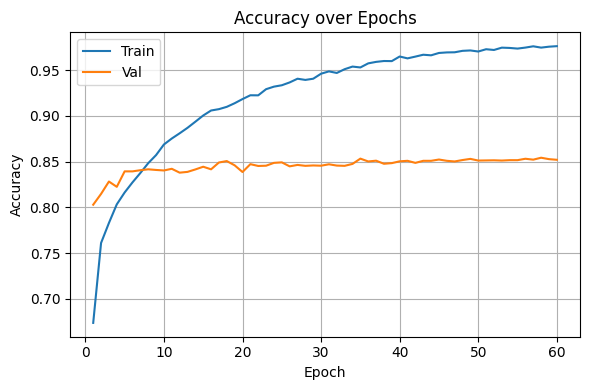

Saved accuracy plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_025315/accuracy_epochs.png

Final evaluation:
Precision: 0.8507, Recall: 0.8543, F1: 0.8508


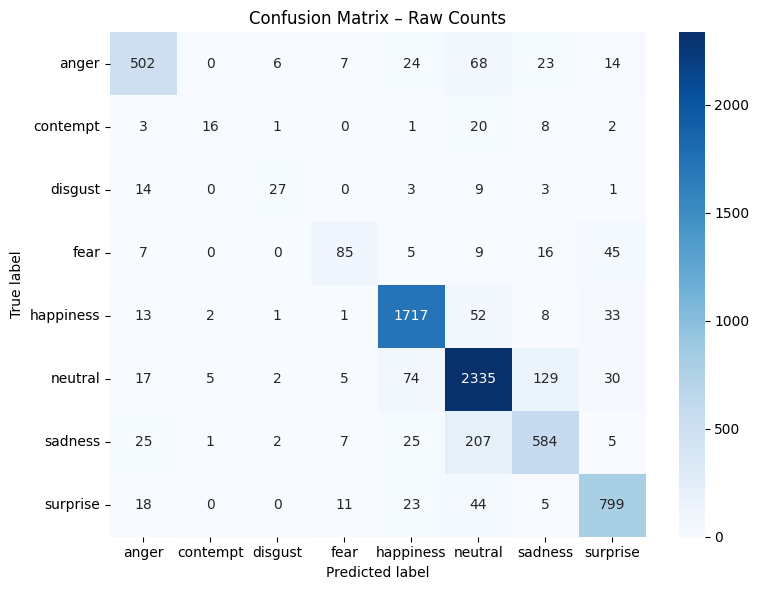

Saved confusion matrix ➜ /home/roberh18/IKT452/Project/outputs/20250421_025315/confusion_matrix.png


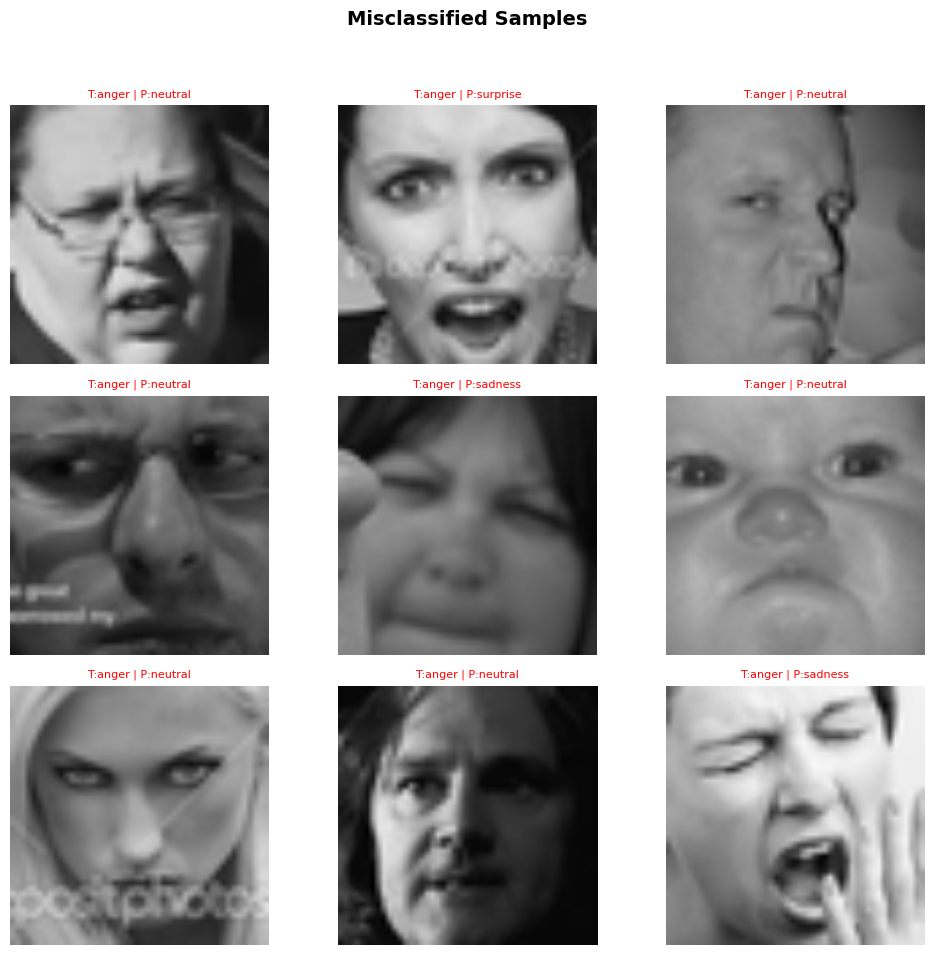

Saved mis‑classified sample grid ➜ /home/roberh18/IKT452/Project/outputs/20250421_025315/misclassified_samples.png
Saved best weights ➜ /home/roberh18/IKT452/Project/outputs/20250421_025315/models/efficientnet_best.pth


In [3]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------------------------------------
# Configurations and Hyper‑parameters
# ------------------------------------------------------------
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "efficientnet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                             # 60 to match best experiment, can be changed
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
# Output folder (works in scripts *and* notebooks)
# ------------------------------------------------------------
try:
    base_dir = Path(__file__).resolve().parent        # running as a script
except NameError:
    base_dir = Path.cwd()                             # running in a notebook

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g. 20250421_140355
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving artefacts to: {OUT_DIR}")

print(f">>>   Model: {MODEL_NAME}, Dataset: FERPlus   <<<")
# ------------------------------------------------------------
# Dataset helpers
# ------------------------------------------------------------

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std (channel‑wise)."""
    print("Calculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# ------------------------------------------------------------
# Transforms & loaders (randaugment_plus default)
# ------------------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

# ------------------------------------------------------------
# Model factory
# ------------------------------------------------------------

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# ------------------------------------------------------------
# Training utilities
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# ------------------------------------------------------------
# Plots – each metric in a separate figure, saved + shown
# ------------------------------------------------------------

epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot ➜ {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot ➜ {acc_path}")

# ------------------------------------------------------------
# Final evaluation & Confusion matrix (+ plot)
# ------------------------------------------------------------

model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix ➜ {cm_path}")

# ------------------------------------------------------------
# Mis‑classified samples helper functions
# ------------------------------------------------------------

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid ➜ {fig_path}")

# ------------------------------------------------------------
# Show some misclassified examples (and save grid)
# ------------------------------------------------------------
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

# ------------------------------------------------------------
# Save model weights last (so folder contains every artefact)
# ------------------------------------------------------------
model_dir = os.path.join(OUT_DIR, "models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
torch.save(best_weights, model_path)
print(f"Saved best weights ➜ {model_path}")


Saving artefacts to: /home/roberh18/IKT452/Project/outputs/20250421_043334
>>>   Model: mobilenet, Dataset: FERPlus   <<<
Calculating mean and std …
Dataset mean:  [0.5077897310256958, 0.5077897310256958, 0.5077897310256958]
Dataset std:   [0.2495584785938263, 0.2495584785938263, 0.2495584785938263]

Begin training …
Epoch   1/60 | Train L: 1.2251 A: 0.6449 | Val L: 0.9929 A: 0.7563 | F1: 0.7449 | 34.4s
Epoch   2/60 | Train L: 1.0556 A: 0.7280 | Val L: 0.9467 A: 0.7755 | F1: 0.7562 | 34.6s
Epoch   3/60 | Train L: 1.0027 A: 0.7542 | Val L: 0.9056 A: 0.8007 | F1: 0.7901 | 33.7s
Epoch   4/60 | Train L: 0.9705 A: 0.7663 | Val L: 0.8889 A: 0.8045 | F1: 0.7897 | 32.6s
Epoch   5/60 | Train L: 0.9427 A: 0.7815 | Val L: 0.8808 A: 0.8081 | F1: 0.8016 | 32.2s
Epoch   6/60 | Train L: 0.9217 A: 0.7923 | Val L: 0.9007 A: 0.7977 | F1: 0.7963 | 34.2s
Epoch   7/60 | Train L: 0.9029 A: 0.7977 | Val L: 0.8667 A: 0.8215 | F1: 0.8132 | 33.4s
Epoch   8/60 | Train L: 0.8836 A: 0.8058 | Val L: 0.8613 A: 0.816

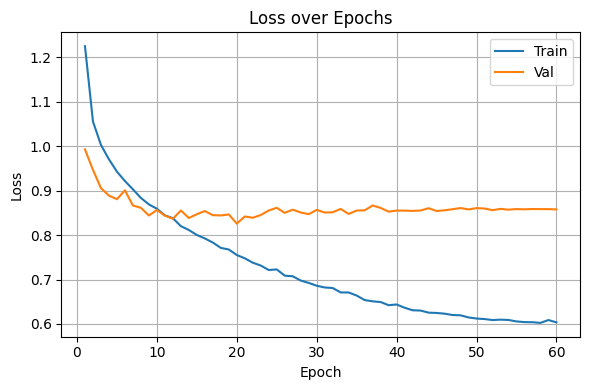

Saved loss plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_043334/loss_epochs.png


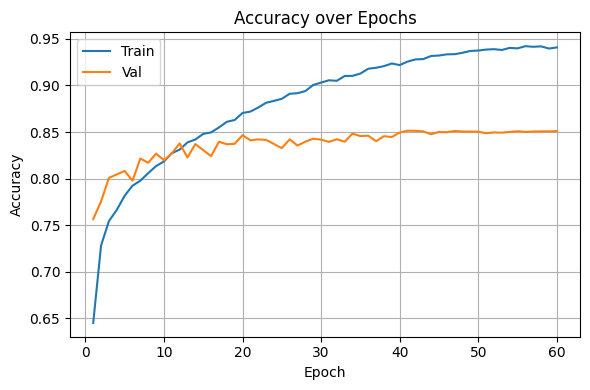

Saved accuracy plot ➜ /home/roberh18/IKT452/Project/outputs/20250421_043334/accuracy_epochs.png

Final evaluation:
Precision: 0.8483, Recall: 0.8512, F1: 0.8482


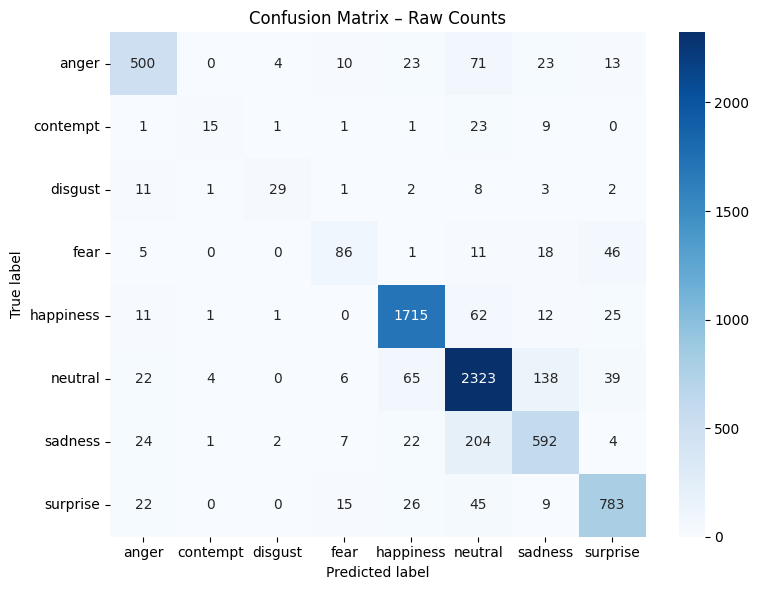

Saved confusion matrix ➜ /home/roberh18/IKT452/Project/outputs/20250421_043334/confusion_matrix.png


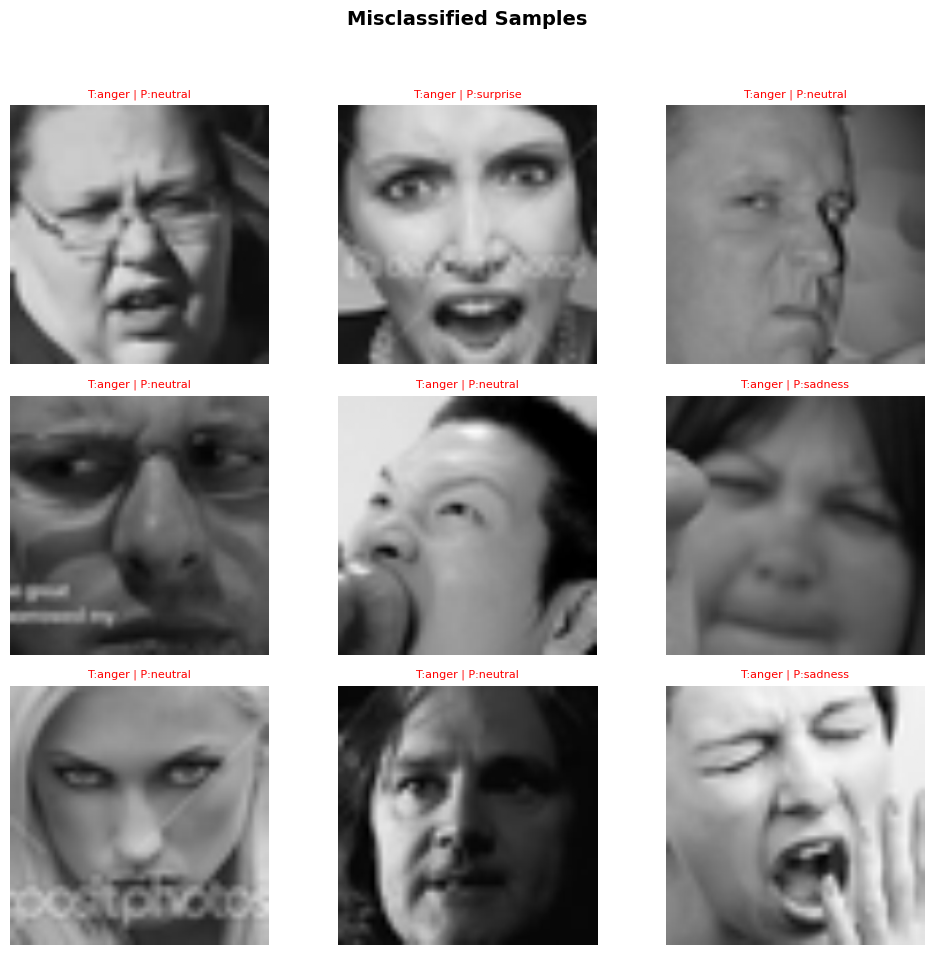

Saved mis‑classified sample grid ➜ /home/roberh18/IKT452/Project/outputs/20250421_043334/misclassified_samples.png
Saved best weights ➜ /home/roberh18/IKT452/Project/outputs/20250421_043334/models/mobilenet_best.pth


In [4]:
import os
import copy
import time
import math
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torchvision.models import EfficientNet_B1_Weights, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------------------------------------
# Configurations and Hyper‑parameters
# ------------------------------------------------------------
# Choose 'efficientnet' or 'mobilenet'
MODEL_NAME   = "mobilenet"
#DATA_DIR     = "/home/roberh18/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
DATA_DIR    = "/home/roberh18/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1/fer2013plus/fer2013"
BATCH_SIZE   = 32
NUM_EPOCHS   = 60                             # 60 to match best experiment, can be changed
LEARNING_RATE= 4e-4
WEIGHT_DECAY = 8e-4
IMAGE_SIZE   = 224
LABEL_SMOOTH = 0.1
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------
# Output folder (works in scripts *and* notebooks)
# ------------------------------------------------------------
try:
    base_dir = Path(__file__).resolve().parent        # running as a script
except NameError:
    base_dir = Path.cwd()                             # running in a notebook

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g. 20250421_140355
OUT_DIR   = base_dir / "outputs" / timestamp
OUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Saving artefacts to: {OUT_DIR}")

print(f">>>   Model: {MODEL_NAME}, Dataset: FERPlus   <<<")

# ------------------------------------------------------------
# Dataset helpers
# ------------------------------------------------------------

def calculate_mean_std(root: str, size: int, batch_size: int):
    """Compute dataset‑wide mean / std (channel‑wise)."""
    print("Calculating mean and std …")
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    ds = datasets.ImageFolder(os.path.join(root, "train"), transform=tf)
    ld = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)

    sum_px = torch.zeros(3)
    sum_sq = torch.zeros(3)
    n      = 0

    for imgs, _ in ld:
        sum_px += imgs.sum(dim=[0, 2, 3])
        sum_sq += (imgs**2).sum(dim=[0, 2, 3])
        n      += imgs.numel() / 3

    mean = sum_px / n
    std  = torch.sqrt(sum_sq / n - mean ** 2)
    return mean.tolist(), std.tolist()


MEAN, STD = calculate_mean_std(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)
print(f"Dataset mean:  {MEAN}\nDataset std:   {STD}")

# ------------------------------------------------------------
# Transforms & loaders (randaugment_plus default)
# ------------------------------------------------------------
train_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5)
])

val_tf = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_set = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_set   = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_tf)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
CLASS_NAMES  = train_set.classes
NUM_CLASSES  = len(CLASS_NAMES)

# ------------------------------------------------------------
# Model factory
# ------------------------------------------------------------

def create_model(name: str, num_classes: int):
    if name == "efficientnet":
        m = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, num_classes))
    elif name == "mobilenet":
        m = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    return m.to(DEVICE)

model = create_model(MODEL_NAME, NUM_CLASSES)

# ------------------------------------------------------------
# Training utilities
# ------------------------------------------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

best_f1 = 0.0
best_weights = copy.deepcopy(model.state_dict())

print("\nBegin training …")
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # ------------- Train -------------
    model.train()
    tl, tc = 0.0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tl += loss.item() * x.size(0)
        tc += (out.argmax(1) == y).sum().item()
    train_loss = tl / len(train_set)
    train_acc  = tc / len(train_set)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ------------- Val -------------
    model.eval()
    vl, vc = 0.0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            vl += loss.item() * x.size(0)
            preds = out.argmax(1)
            vc += (preds == y).sum().item()
            all_preds.extend(preds.cpu().tolist())
            all_true.extend(y.cpu().tolist())
    val_loss = vl / len(val_set)
    val_acc  = vc / len(val_set)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
    rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
    f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)

    print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | "
          f"Train L: {train_loss:.4f} A: {train_acc:.4f} | "
          f"Val L: {val_loss:.4f} A: {val_acc:.4f} | "
          f"F1: {f1:.4f} | {time.time() - t0:.1f}s")

    # keep best weights
    if f1 > best_f1:
        best_f1, best_weights = f1, copy.deepcopy(model.state_dict())
    scheduler.step()

# ------------------------------------------------------------
# Plots – each metric in a separate figure, saved + shown
# ------------------------------------------------------------

epochs = range(1, NUM_EPOCHS + 1)

# Loss plot
fig_loss = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss_hist, label="Train")
plt.plot(epochs, val_loss_hist,   label="Val")
plt.title("Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(); plt.legend()
plt.tight_layout()
loss_path = os.path.join(OUT_DIR, "loss_epochs.png")
fig_loss.savefig(loss_path)
plt.show()
print(f"Saved loss plot ➜ {loss_path}")

# Accuracy plot
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train")
plt.plot(epochs, val_acc_hist,   label="Val")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(); plt.legend()
plt.tight_layout()
acc_path = os.path.join(OUT_DIR, "accuracy_epochs.png")
fig_acc.savefig(acc_path)
plt.show()
print(f"Saved accuracy plot ➜ {acc_path}")

# ------------------------------------------------------------
# Final evaluation & Confusion matrix (+ plot)
# ------------------------------------------------------------

model.load_state_dict(best_weights)
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu())
        all_true.extend(y.cpu())

prec = precision_score(all_true, all_preds, average="weighted", zero_division=0)
rec  = recall_score(all_true, all_preds, average="weighted", zero_division=0)
f1   = f1_score(all_true, all_preds, average="weighted", zero_division=0)
print("\nFinal evaluation:")
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(all_true, all_preds)

fig_cm, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Raw Counts")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
fig_cm.savefig(cm_path)
plt.show()
print(f"Saved confusion matrix ➜ {cm_path}")

# ------------------------------------------------------------
# Mis‑classified samples helper functions
# ------------------------------------------------------------

def get_misclassified_samples(model_to_evaluate, data_loader, device_to_use, max_images_to_get=9):
    """Return up to *max_images_to_get* (img, pred, true) tuples that were mis‑classified."""
    model_to_evaluate.eval()
    misclassified = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs   = imgs.to(device_to_use)
            labels = labels.to(device_to_use)
            outputs = model_to_evaluate(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(imgs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                    if len(misclassified) >= max_images_to_get:
                        return misclassified
    return misclassified


def show_misclassified_images(mis_list, class_name_list, title="Misclassified Samples", norm_mean=None, norm_std=None):
    if not mis_list:
        print("INFO: No misclassified images to show.")
        return

    num_img = len(mis_list)
    grid   = int(math.ceil(num_img ** 0.5))
    fig, axes = plt.subplots(grid, grid, figsize=(10, 10))
    axes = np.array(axes).flatten()

    for ax in axes[num_img:]:  # hide unused axes
        ax.axis("off")

    for i, (img_t, pred_idx, true_idx) in enumerate(mis_list):
        img_disp = img_t.clone()
        if norm_mean is not None and norm_std is not None:
            mean_t = torch.tensor(norm_mean).view(3, 1, 1)
            std_t  = torch.tensor(norm_std).view(3, 1, 1)
            img_disp = torch.clamp(img_disp * std_t + mean_t, 0, 1)
        img_np = img_disp.permute(1, 2, 0).numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f"T:{class_name_list[true_idx]} | P:{class_name_list[pred_idx]}", fontsize=8, color="red")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(OUT_DIR, "misclassified_samples.png")
    fig.savefig(fig_path)
    plt.show()
    print(f"Saved mis‑classified sample grid ➜ {fig_path}")

# ------------------------------------------------------------
# Show some misclassified examples (and save grid)
# ------------------------------------------------------------
mis_samples = get_misclassified_samples(model, val_loader, DEVICE, max_images_to_get=9)
show_misclassified_images(mis_samples, CLASS_NAMES, norm_mean=MEAN, norm_std=STD)

# ------------------------------------------------------------
# Save model weights last (so folder contains every artefact)
# ------------------------------------------------------------
model_dir = os.path.join(OUT_DIR, "models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"{MODEL_NAME}_best.pth")
torch.save(best_weights, model_path)
print(f"Saved best weights ➜ {model_path}")

